# An example pipeline
Using the created classes in the data_utils and utils, we can create fairly efficient pipeline, without running much code.
About the design choices, we chose a pure tensorflow approach using tf datasets, instead of keras imagedatagenerator, since it is quite a bit faster: https://www.tensorflow.org/tutorials/load_data/images   

The following cells will show an example of how to use each function, hopefully also explaining the thought behind the pipeline: avoid repeating alot of routine code, whilst providing flexibility.
   
**Note**: We assume that you have tiled the data into 16x128x128 images, that is located in the data/train folder. See the tiling notebook for more information.
   
**Note2**: Some of this is still work in progress. Ideally, neural networks are created in their own separate files, and then imported and wrapped using the Network class defined in the models folder. Since this is not finished, we will not use it for now in this example. 

In [1]:
!nvidia-smi
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Wed Jun 24 23:37:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40           On   | 00000000:04:00.0 Off |                    0 |
| N/A   37C    P0    59W / 250W |      0MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40           On   | 00000000:82:00.0 Off |                    0 |
| N/A   26C    P8    17W / 250W |      0MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
%load_ext tensorboard

# load tensorflow dependencies
import tensorflow as tf
from classification_models.tfkeras import Classifiers
from tensorflow.keras.utils import to_categorical
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 16 bit precision computing
from tensorflow.keras.mixed_precision import experimental as mixed_precision
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import skimage.io
import sys
from functools import partial

from sklearn.model_selection import StratifiedKFold
import time

sys.path.insert(0,'..')

# custom packages
from preprocessing.utils.data_loader import PandasDataLoader
from preprocessing.generators import TiffGenerator, TiffFromCoords
from preprocessing.utils.mat_transforms import tf_tile2mat, tf_tile2square
from utils.utils import set_gpu_memory, seed_all
from model.models import ResNet50_bigimg
from model.network import Network

# Augmentation packages

# custom stain augmentation
from preprocessing.augmentations import StainAugment

import albumentations as A
from albumentations import (
    Flip, ShiftScaleRotate, RandomRotate90,
    ShiftScaleRotate, Blur, OpticalDistortion, RandomBrightnessContrast, 
    OneOf, Compose, RandomScale, ElasticTransform, GaussNoise, GaussianBlur,
    RandomBrightness, RandomContrast
)


2.2.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Setup

In [3]:
seed_all(20)
# control for the gpu memory, and number of used gpu's
set_gpu_memory(device_type='GPU')
# see the utils functions which seeds are set
# tensorflow ops still have to be seeded manually...
seed_all()

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

1 Physical GPUs, 1 Logical GPUs
Compute dtype: float16
Variable dtype: float32


## Directory processing and declaring constants

Notice that most of the constants are quite straightforward, except for the fact there is not image size defined anywhere. This is because the number of tiles, as well as the image sizes are saved in the coordinate files

In [23]:
# ------------------
# Directories
# ------------------
DATA_DIR = '../data'  # General path to the data dir
IMG_DIR = '../data/train_images'  # Path to the TILED images
TRAIN_MASKS_DIR = '../data/masks'  # Path to the masks

# ------------------
# Data constants
# ------------------
# although the dataset is split into folds, this notebook does not cover fold training
NFOLDS = 4  # number of folds to use for training/validation (cross validation)
SEED=5  # the seed TODO: REPLACE THIS WITH A FUNCTION THAT SEEDS EVERYTHING WITH SEED
TRAIN_FOLD=0  # select the first fold for training/validation

# ------------------
# Network parameters
# ------------------

# the network parameters are based on the TiffFromCoords generator

# some of these parameters might disappear in a future release
NUM_CLASSES = 6 
BATCH_SIZE = 4
MAX_NUM_TILES = 36 # the maximum numbers of tiles to use (0 < max_num_tiles < num_tiles in coords file)
LEARNING_RATE = 1e-3

# the coordinates to load
# the coordinates file holds information about tile level used
# to generate the coordinates, number of tiles, image size, and background (padding values)
coords = np.load('../coordinates/1-36-256-255.npy',allow_pickle=True)

# A function that changes from a list of tiles to a single big image
# note that this works best if the list can form a square (e.g., 5x5, or 6x6)
img_transform_func = partial(tf_tile2mat, row=6, col=6) # big image
img_transform_func = None # list of tiles

## Create folds for K fold validation
The class below returns a pandas dataframe with an added 'split' column. The split column contains the fold index, which can in turn be used for cross validation.

Notice also that there are skip_csv and skip_list arguments. The skip_csv arg is a path to a file with image id's of slides that should/could be skipped, since they are faulty due to pen mark. The skip_list argument provides an extra handle to filter out only several reasons. For example, if we only want to filter out faulty images with the reason "no masks", we can do that by adding it to the skip_list.

In [24]:
# an example: loading the skip dataframe and listing the possible reasons
skip_df = pd.read_csv(Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'))
print("possible faulty slide reasons", skip_df['reason'].unique())

fold_df = PandasDataLoader(images_csv_path=Path(DATA_DIR) / Path('train.csv'),
                           skip_csv=Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'), 
                           skip_list=[])

# we create a possible stratification here, the options are by isup grade, or further distilled by isup grade and data provider
# stratified_isup_sample or stratified_isup_dp_sample, we use the former.

fold_df = fold_df.stratified_isup_sample(NFOLDS, SEED)

# we can create training/validation splits from the fold column
train_df = fold_df[fold_df['split'] != TRAIN_FOLD]
valid_df = fold_df[fold_df['split'] == TRAIN_FOLD]

display(train_df)
display(valid_df)

possible faulty slide reasons ['marks' 'No Mask' 'Background only'
 'No cancerous tissue but ISUP Grade > 0' 'tiss' 'blank']
********************
The training dataframe shape before filtering:(10616, 4)
The skip dataframe has shape: (675, 2), with reasons ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
Filtering based on the following columns: ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
number of duplicates in the skip df: (13, 2)
Training dataframe after filtering: (9954, 4)
Number of rows removed by filter: 662
********************


image_id data_provider  isup_grade  \
0      0005f7aaab2800f6170c399693a96917    karolinska           0   
1      000920ad0b612851f8e01bcc880d9b3d    karolinska           0   
2      0018ae58b01bdadc8e347995b69f99aa       radboud           4   
3      001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4   
4      001d865e65ef5d2579c190a0e0350d8f    karolinska           0   
...                                 ...           ...         ...   
10622  ffcd99c47e57ad2934dc6bbf5edf6675    karolinska           0   
10624  ffd2841373b39792ab0c84cccd066e31       radboud           0   
10625  ffdc59cd580a1468eac0e6a32dd1ff2d       radboud           5   
10626  ffe06afd66a93258f8fabdef6044e181       radboud           0   
10628  ffe9bcababc858e04840669e788065a1       radboud           4   

      gleason_score  split  
0               0+0      1  
1               0+0      3  
2               4+4      2  
3               4+4      3  
4               0+0      1  
...             ...    ...  
10622           0+0      2  
10624      negative      2  
10625           4+5      2  
10626      negative      3  
10628           4+4      1  

[7465 rows x 5 columns]

image_id data_provider  isup_grade  \
5      002a4db09dad406c85505a00fb6f6144    karolinska           0   
6      003046e27c8ead3e3db155780dc5498e    karolinska           1   
10     00412139e6b04d1e1cee8421f38f6e90    karolinska           0   
13     004f6b3a66189b4e88b6a01ba19d7d31    karolinska           1   
29     00c15b23b30a5ba061358d9641118904       radboud           5   
...                                 ...           ...         ...   
10596  ff339e5fa7be6af83c1b43796092398f    karolinska           4   
10603  ff596d5292ab979e9ba7291d0743b3fb    karolinska           0   
10618  ffc005d56a21efbd034425623f596984    karolinska           2   
10621  ffcbb41626c9267c5c20c4804bd5639a       radboud           4   
10623  ffcee00fd033d3ece1408035a7fd4ea7    karolinska           1   

      gleason_score  split  
5               0+0      0  
6               3+3      0  
10              0+0      0  
13              3+3      0  
29              4+5      0  
...             ...    ...  
10596           4+4      0  
10603           0+0      0  
10618           3+4      0  
10621           3+5      0  
10623           3+3      0  

[2489 rows x 5 columns]

In [25]:
FOLDED_NUM_TRAIN_IMAGES = train_df.shape[0]
FOLDED_NUM_VALID_IMAGES = valid_df.shape[0]
STEPS_PER_EPOCH = FOLDED_NUM_TRAIN_IMAGES // BATCH_SIZE  # Calculate the steps for keras
VALIDATION_STEPS = FOLDED_NUM_VALID_IMAGES // BATCH_SIZE  # Calculate the same for validation


print('*'*20)
print('Notebook info')
print('Training data : {}'.format(FOLDED_NUM_TRAIN_IMAGES))
print('Validing data : {}'.format(FOLDED_NUM_VALID_IMAGES))
print('Categorical classes : {}'.format(NUM_CLASSES))
print('*'*20)

********************
Notebook info
Training data : 7465
Validing data : 2489
Categorical classes : 6
********************


## Generate dataset
Since we are working with the tf dataset api, we need to pair the actual images with their id's, and convert them to a tf dataset. This is all done for us under the hood in the PNGTileGenerator class
   
**Note:** Tensorflow was at it again during debugging. I wanted to use a tf.vectorized_map function which is more efficient, but this gave low level tensorflow errors. As a result, I had to use map_fn which uses up more resources.

## augmentation functions
Currently only some color changes. The histomicstk package is really slow though. Probably due to masking and changing to H&E colour space.

In [26]:
R = Compose([RandomRotate90(p=0.5), Flip(p=0.5)])
S = Compose([RandomScale(scale_limit=0.1, interpolation=1, p=0.5)])
C = Compose([StainAugment(p=0.9)])
E = Compose([ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=0.5)])


BRIGHT = Compose([RandomBrightness(limit=0.12, p=0.5)])
CONTR = Compose([RandomContrast(limit=0.12, p=0.5)])

B = Compose([GaussianBlur(blur_limit=5, p=0.5)])
G = Compose([GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5)])



In [27]:
def aug_routine(image):
    R = Compose([RandomRotate90(p=0.5), Flip(p=0.5)])
    #S = Compose([RandomScale(scale_limit=0.1, interpolation=1, p=0.5)])
    C = Compose([StainAugment(p=0.9)])
    #E = Compose([ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=0.5)])

    BRIGHT = Compose([RandomBrightness(limit=0.10, p=0.5)])
    CONTR = Compose([RandomContrast(limit=0.10, p=0.5)])    
    
    B = Compose([GaussianBlur(blur_limit=5, p=0.5)])
    G = Compose([GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5)])
    augment = Compose([C], p=0.9)
    aug_op = augment(image=image)
    image = aug_op['image']
    return image

def flip(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_flip_left_right(x, seed=1)
    x = tf.image.random_flip_up_down(x, seed=1)

    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, 
                          tf.random.uniform(shape=[], 
                                               minval=0, 
                                               maxval=4, 
                                               dtype=tf.int32, 
                                               seed=1))


augments = [flip, rotate]

In [28]:
data = TiffFromCoords(coords=coords,
                      df=train_df, 
                      tiff_level=1,
                      img_dir=IMG_DIR, 
                      batch_size=BATCH_SIZE, 
                      max_num_tiles=MAX_NUM_TILES,
                      aug_func=None,
                      tf_aug_list = augments,
                      one_hot=False,
                      img_transform_func=img_transform_func,
                      base_sample_factor=4,
                      coord_shuffle=False,
                      undersampling_coef=0,
                      oversampling_coef=0)
                 
# do not use augmentation for the val_data, if aug_func is empty (None default), then no augmentation is used.
val_data = TiffFromCoords(coords = coords,
                         df=valid_df, 
                         tiff_level=1,
                         img_dir=IMG_DIR, 
                         max_num_tiles=MAX_NUM_TILES,
                         batch_size=BATCH_SIZE, 
                         aug_func=None,
                         one_hot=False,
                         img_transform_func=img_transform_func)



In [29]:
for x in data().take(1):
    print(x[0].shape)

(4, 36, 256, 256, 3)


### Displaying batches
The display_batch function displays the data training batch with augmentations. Since the val_data was initialized without any aug func, it has no augmentation routine. The number of batches can be controlled by the plot grid argument. The number of tiles within each batch is controlled by the rows and cols arguments.
   
Notice that the results are green rather than pink/purple. This is because the image is processed as "1-image", which flips around the values, and results in a green color. In order to get back the original image representation, simply transform it back by computing 1-image again

done reshaping image (4, 1280, 1280, 3)
done plotting


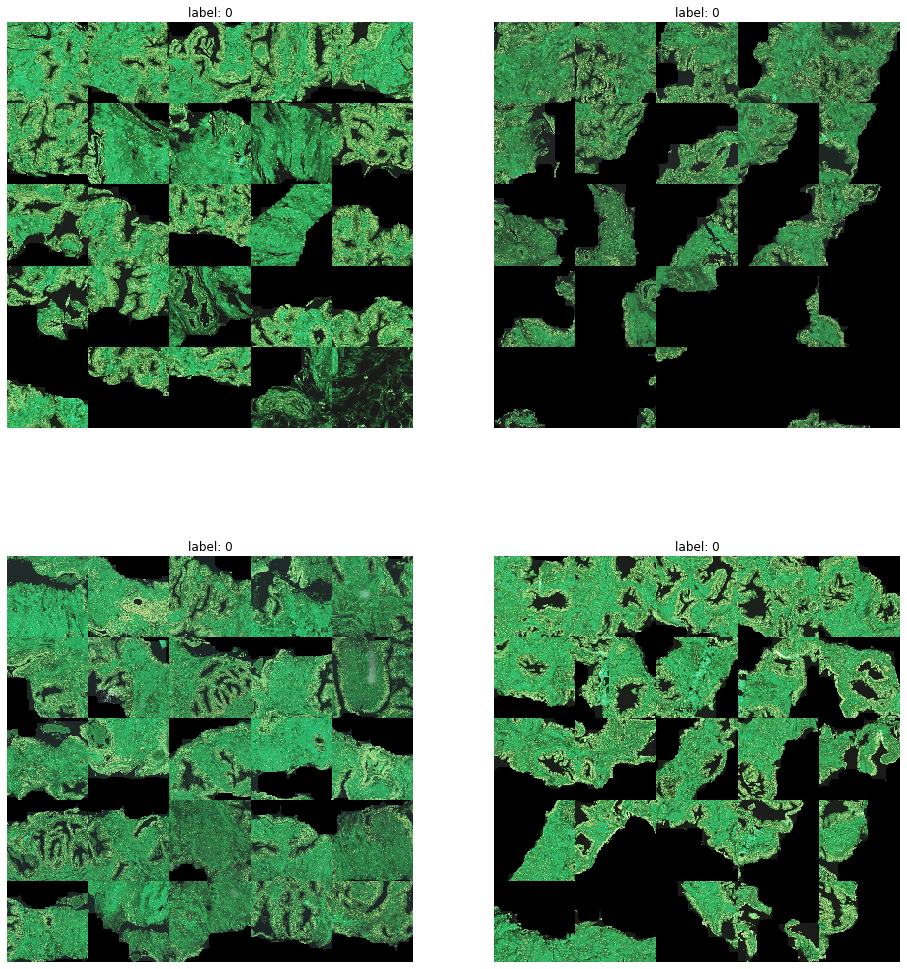

In [11]:
# new
data.display_batch(plot_grid=(2,2), rows=6, cols=6)

done reshaping image (4, 1280, 1280, 3)
done plotting


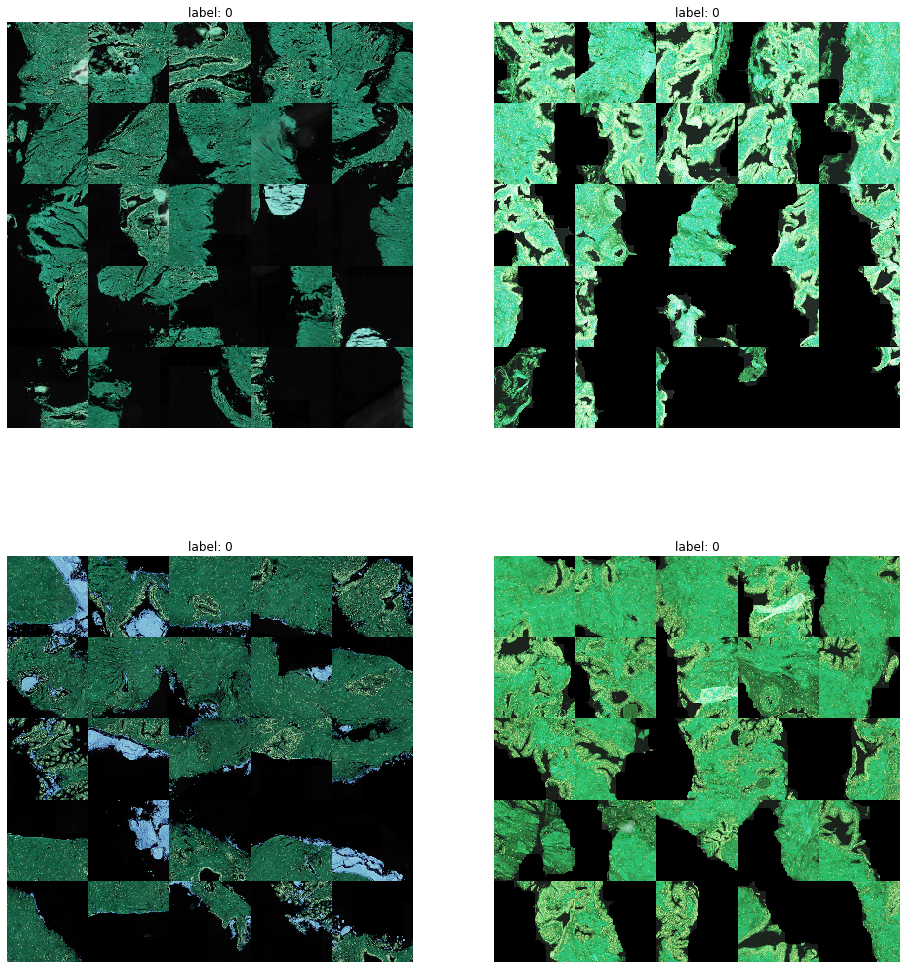

In [12]:
data.display_batch(plot_grid=(2,2), rows=6, cols=6)

done reshaping image (16, 1280, 1280, 3)
done plotting


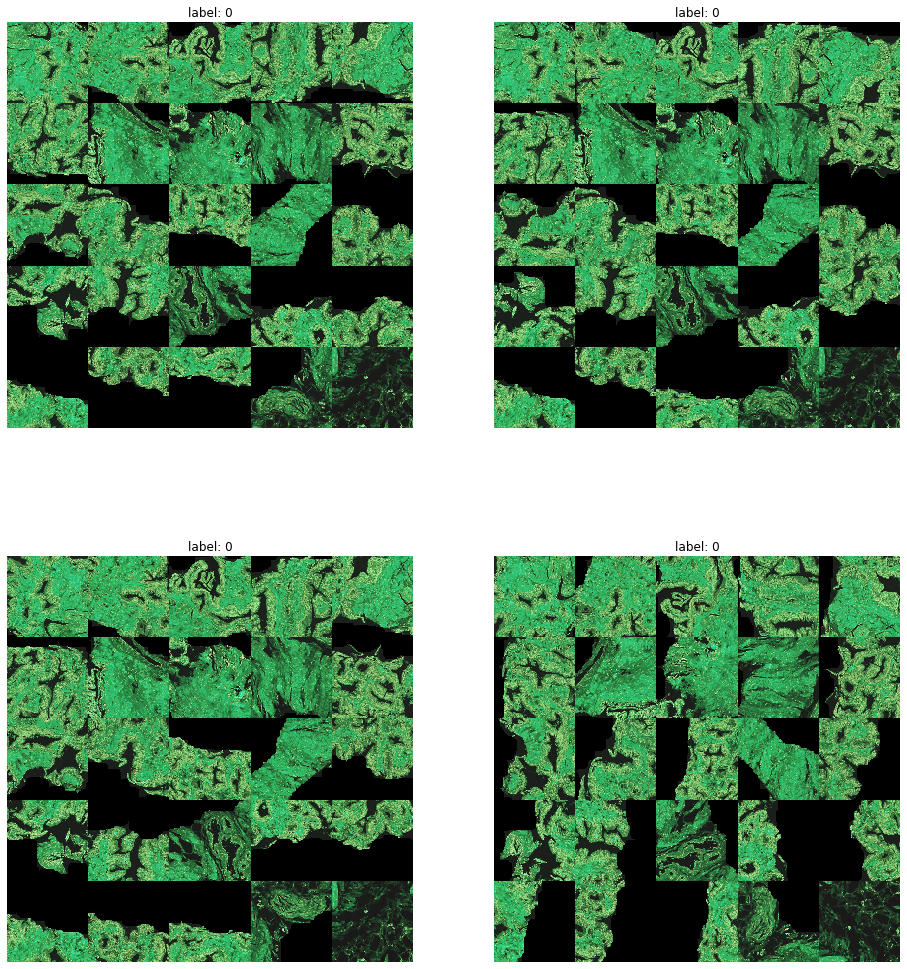

In [13]:
data.display_augmentation(plot_grid=(2,2), rows=1, cols=3)

done reshaping image (4, 1280, 1280, 3)


IndexError: index 4 is out of bounds for axis 0 with size 4

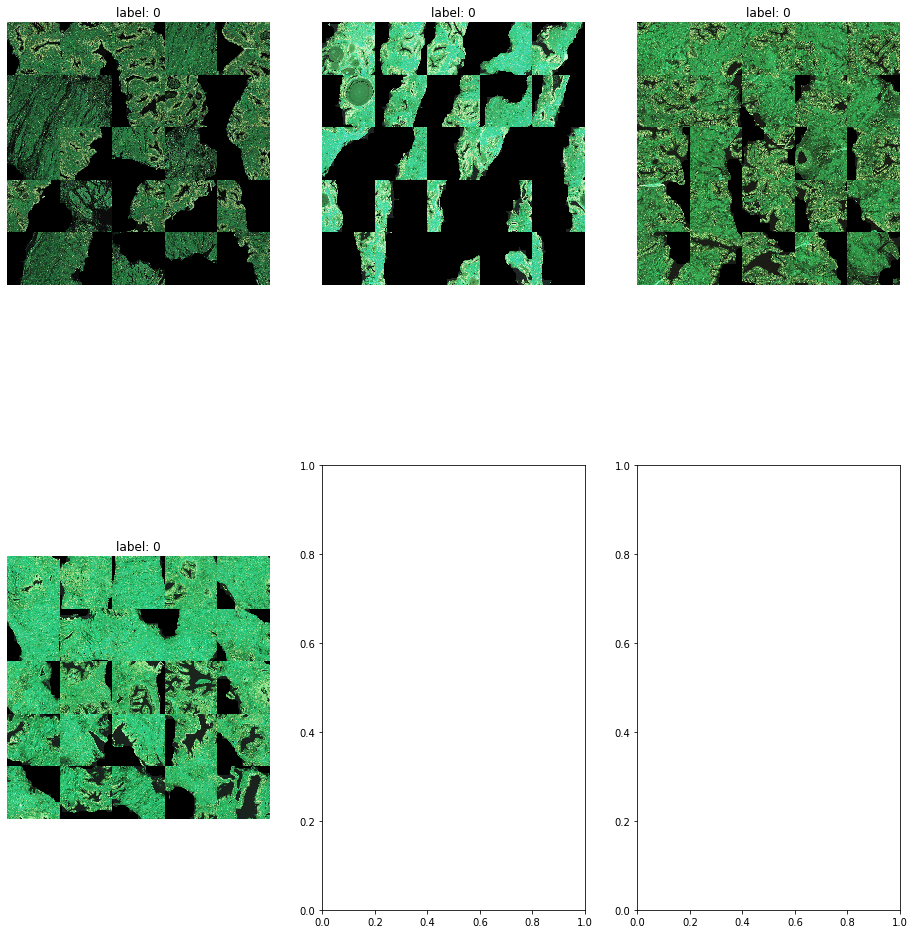

In [14]:
val_data.display_batch(plot_grid=(2,3))

## Building model using Tensorflow Keras API's
The models folder contains several models that can be loaded, which we will do in this notebook as well.
After this, it is wrapped in a Network class which loads all of the most common callbacks and metrics, which can also be expanded with custom losses, metrics, callbacks and other parameters. See the respective Network class for more details.

In [30]:
# load resnet 34 with 36 tiles and 256 image size
from model.models import ResNet34_tile
model = ResNet34_tile(36, 256)
model.summary()

Model: "tile_model_resnets_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8, 8, 512)         21302473  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  262656    
_________________________________________________________________
dense_3 (Dense)              multiple                  513       
Total params: 21,565,642
Trainable params: 21,550,276
Non-trainable params: 15,366
_________________________________________________________________


In [31]:
optimizer = Adam(lr=1e-3)

# wrap the Keras.Optimizer with gradient accumulation of 2 steps
lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=4,
    verbose=1,
    min_lr=1e-7
)

# custom callbacks
custom_callbacks = [lrreducer]

# qwk is added by default in network class
custom_metrics = [tf.keras.metrics.RootMeanSquaredError()]
custom_loss = tf.keras.losses.MeanSquaredError()

In [32]:
network = Network(model, 
                  num_classes=6,
                  sparse_labels=True,
                  regression=True,
                  custom_metrics=custom_metrics,
                  custom_optimizer=optimizer,
                  custom_loss=custom_loss,
                  use_tf_kappa=False)


In [14]:
network.train(
    dataset=data(),
    val_dataset=val_data(mode="validation"),
    epochs=NUM_EPOCHS,
    class_weights=None,
    custom_callbacks=custom_callbacks,
    save_weights_name=weights_fname,
    tb_logdir=f"./logs/{config.MODEL_NAME}",
)

NameError: name 'NUM_EPOCHS' is not defined

## Getting inference statistics

In [33]:
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [47]:
network.load_weights('../ResNet34_tile_1_20200624-224754_0_bestQWK.h5')

In [49]:
thresholds = [0.5, 1.5, 2.5, 3.5, 4.5]
def thresh2int(thresholds, preds_raw):
    y_hat=copy.deepcopy(preds_raw)
    
    for i,pred in enumerate(y_hat):
        if   pred < thresholds[0]: y_hat[i] = 0
        elif pred < thresholds[1]: y_hat[i] = 1
        elif pred < thresholds[2]: y_hat[i] = 2
        elif pred < thresholds[3]: y_hat[i] = 3
        elif pred < thresholds[4]: y_hat[i] = 4
        else: y_hat[i] = 5
    return y_hat.astype('int')


valid_df = fold_df[fold_df['split'] == TRAIN_FOLD]
radboud_valid_df = valid_df[valid_df['data_provider'] == 'radboud']
karolinska_valid_df = valid_df[valid_df['data_provider'] == 'karolinska']

val_data_radboud = TiffFromCoords(coords = coords,
                                 df=radboud_valid_df, 
                                 img_dir=IMG_DIR, 
                                 max_num_tiles= MAX_NUM_TILES,
                                 tiff_level=1,
                                 batch_size=BATCH_SIZE, 
                                 aug_func=None,
                                 one_hot=False,
                                 img_transform_func=img_transform_func)

val_data_karolinska = TiffFromCoords(coords = coords,
                                     df=karolinska_valid_df, 
                                     img_dir=IMG_DIR, 
                                     max_num_tiles= MAX_NUM_TILES,
                                     tiff_level=1,
                                     batch_size=BATCH_SIZE, 
                                     aug_func=None,
                                     one_hot=False,
                                     img_transform_func=img_transform_func)

preds_radboud = model.predict(val_data_radboud(mode='validation'),verbose=1)
preds_isup_radboud = thresh2int(thresholds, preds_radboud)
isups_radboud = [int(x) for x in val_data_radboud.df['isup_grade'].to_list()]
tuples_radboud = val_data_radboud.image_ids


preds_karolinska = model.predict(val_data_karolinska(mode='validation'),verbose=1)
preds_isup_karolinska = thresh2int(thresholds, preds_karolinska)
isups_karolinska = [int(x) for x in val_data_karolinska.df['isup_grade'].to_list()]
tuples_karolinska = val_data_karolinska.image_ids

346/346 [==============================] - 171s 493ms/step


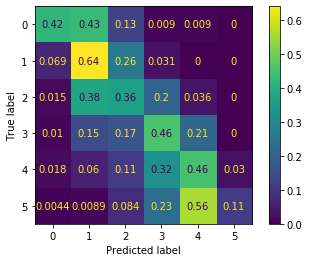

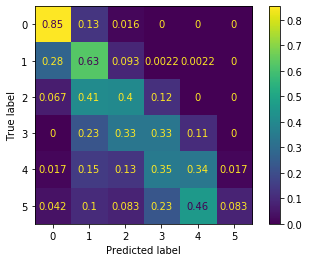

In [50]:
cm_radboud = confusion_matrix(isups_radboud,preds_isup_radboud ,normalize='true')
ConfusionMatrixDisplay(cm_radboud,display_labels=['0','1','2','3','4','5']).plot()

cm_karolinska = confusion_matrix(isups_karolinska,preds_isup_karolinska ,normalize='true')
ConfusionMatrixDisplay(cm_karolinska,display_labels=['0','1','2','3','4','5']).plot()

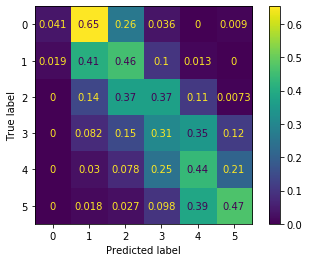

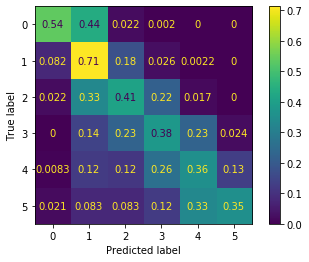

In [46]:
cm_radboud = confusion_matrix(isups_radboud,preds_isup_radboud ,normalize='true')
ConfusionMatrixDisplay(cm_radboud,display_labels=['0','1','2','3','4','5']).plot()

cm_karolinska = confusion_matrix(isups_karolinska,preds_isup_karolinska ,normalize='true')
ConfusionMatrixDisplay(cm_karolinska,display_labels=['0','1','2','3','4','5']).plot()

In [ ]:
lbl_value_counts = train_df["isup_grade"].value_counts()
print(lbl_value_counts)
lbl_probs = lbl_value_counts / sum(lbl_value_counts)
print(lbl_probs)

In [ ]:
data_probs = pd.DataFrame({'class_prob': lbl_probs, 'isup_grade': [0,1,2,3,4,5]})
train_df = train_df.merge(data_probs, on='isup_grade')
train_df['class_target_prob'] = 1/6
train_df